In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from skew_correction.model import MyModelModule, TimmClassifier
import torch
import torch.nn.functional as F
import timm
import os
from torchvision import transforms
import matplotlib.pyplot as plt
from skew_correction.helper import read_raw_image, get_images_in_dir, pil2np, np2pil, tensor2pil, get_skew, hough_transform, remove_padding
from skew_correction.constants import root_dir, angle2label, label2angle, device, model_url
from skew_correction.model import TimmClassifier
from skew_correction.data import tensor_transform
from skew_correction.rectify_skew import rectify_image, ensure_model
from time import time

/home/deepam_minda_farmart_co/anaconda3/envs/vqa/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# from ds_utils.gcp_utils import download_file_url_from_gcp_to_tempdir
# ensure_model()

In [17]:
## 
def checkpoint_to_model(model_string, ckpt_path):
    """
    changes plmodule to plain pytorch models. only implented for our model classes (timclassfier and mymodelmodule)
    Args:
        model_string (str): name to save model by
        ckpt_path (str): pl module checkpoint
    """

    ## check for compatibility b/q model and ckpt and automate finding when it can be converted using dictionary keys parsing..

    try:
        ckpt = torch.load(ckpt_path)
        l = len("model.")
        new_state_dict = {k[l:]:v for k, v in ckpt['state_dict'].items()}
        model_path = "/home/deepam_minda_farmart_co/fmt/skew_correction/models/densenet121-98acc.pth"
        torch.save(new_state_dict, model_path)
    except Exception as e:
        print(e)

    return


# torch.save(new_state_dict, model_path)

<All keys matched successfully>

In [21]:
model_path = "/home/deepam_minda_farmart_co/fmt/skew_correction/models/densenet121-98acc.pth"
model = TimmClassifier('densenet121', pretrained=False, num_classes=4, in_chans=1)
model.load(model_path)
model

TimmClassifier(
  (backbone): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNormAct2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): DenseBlock(
        (denselayer1): DenseLayer(
          (norm1): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNormAct2d(
            128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv2): Conv2d(128, 32,

In [22]:
imgpaths = get_images_in_dir('../data/rotated/raw/', return_path=True)

classical rectify done in 3.0s
model prediction done in 0.83s
final rectify done in 0.05s
Total skew_correction done in 3.88s


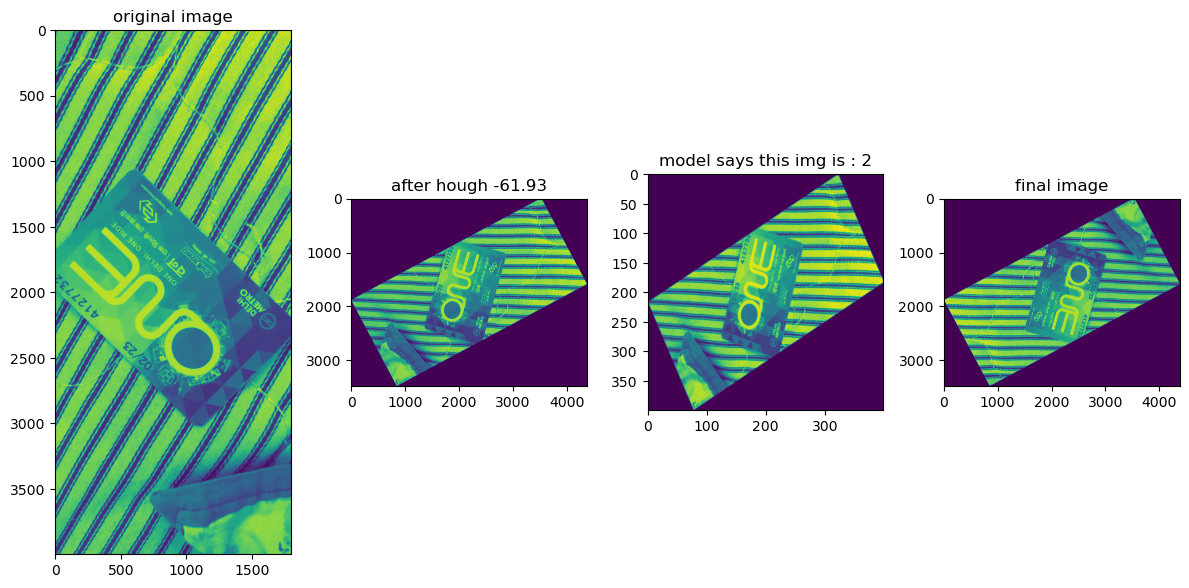

In [32]:
img = read_raw_image(imgpaths[2])

fixed_img = rectify_image(model=model, path=imgpaths[0], debug=True)

In [30]:
def predict_onebyone_in_dir(folder='../data/rotated/predict/', debug=True, max=10, save_to_dir=False, shuffle=False, model=None):
    
    imgpaths = get_images_in_dir(folder, return_path=True, shuffle=shuffle)

    for idx, path in enumerate(imgpaths):
        if idx>max:
            break
        
        output_file = os.path.join(root_dir, "data/fixed_images/") + path.split('/')[-1]
        fixed_img = rectify_image(model=model, path=path, debug=debug)

        t = time()
        if save_to_dir:
            fixed_img.save(output_file)
            print(f"saving done in {round(time() - t, 2)}s")
            print(f"saved to {output_file}")


classical rectify done in 0.43s
model prediction done in 1.0s
final rectify done in 0.01s
Total skew_correction done in 1.44s


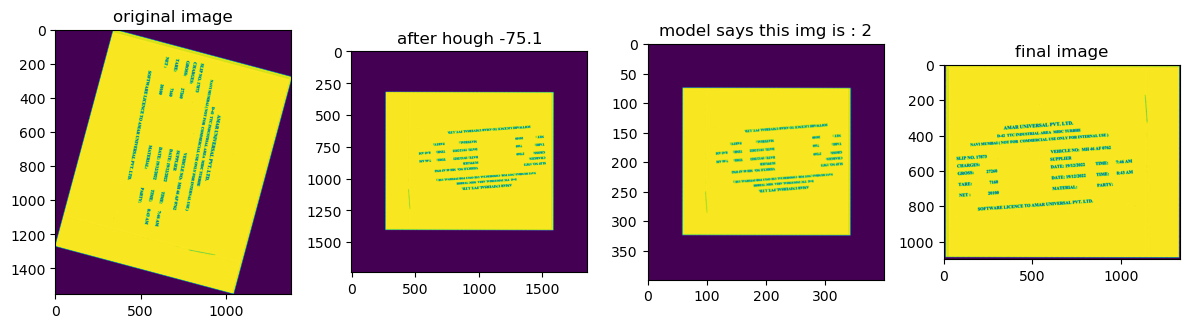

classical rectify done in 0.17s
model prediction done in 1.07s
final rectify done in 0.0s
Total skew_correction done in 1.24s


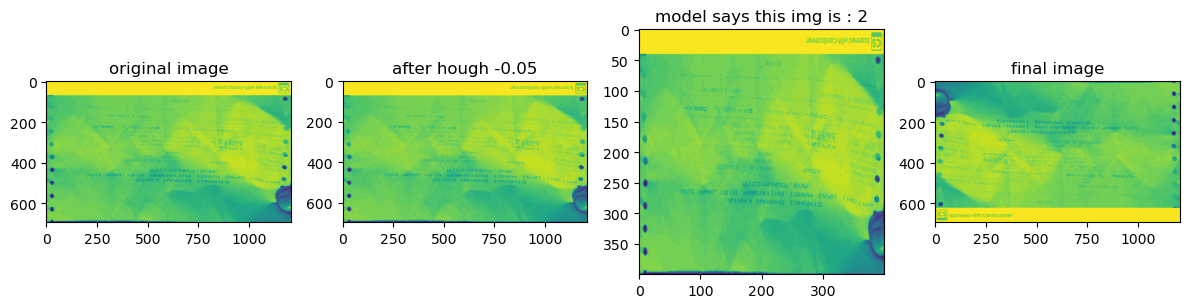

classical rectify done in 0.22s
model prediction done in 0.61s
final rectify done in 0.01s
Total skew_correction done in 0.83s


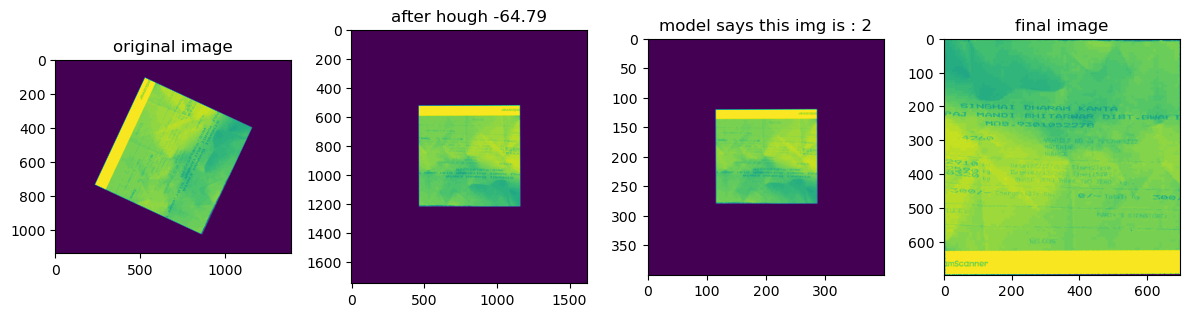

classical rectify done in 0.29s
model prediction done in 1.07s
final rectify done in 0.0s
Total skew_correction done in 1.36s


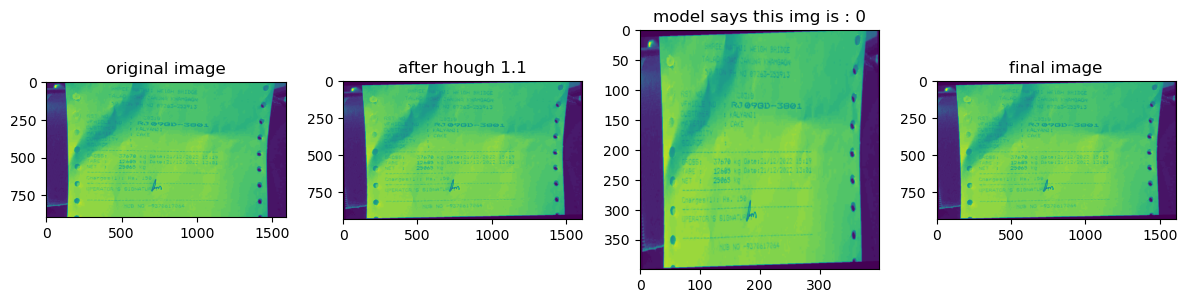

classical rectify done in 0.3s
model prediction done in 0.71s
final rectify done in 0.0s
Total skew_correction done in 1.01s


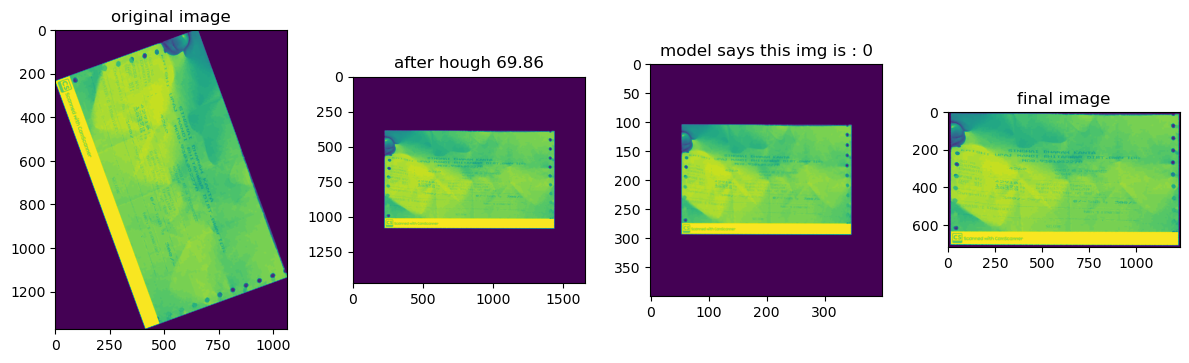

classical rectify done in 5.35s
model prediction done in 0.8s
final rectify done in 0.04s
Total skew_correction done in 6.2s


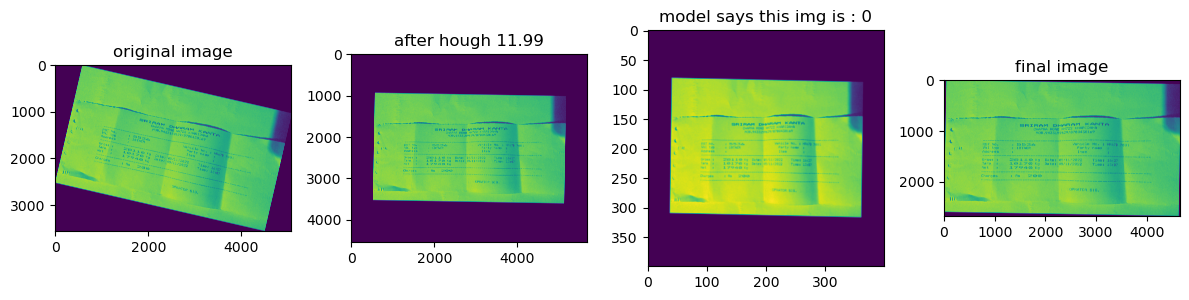

classical rectify done in 2.18s
model prediction done in 0.71s
final rectify done in 0.05s
Total skew_correction done in 2.93s


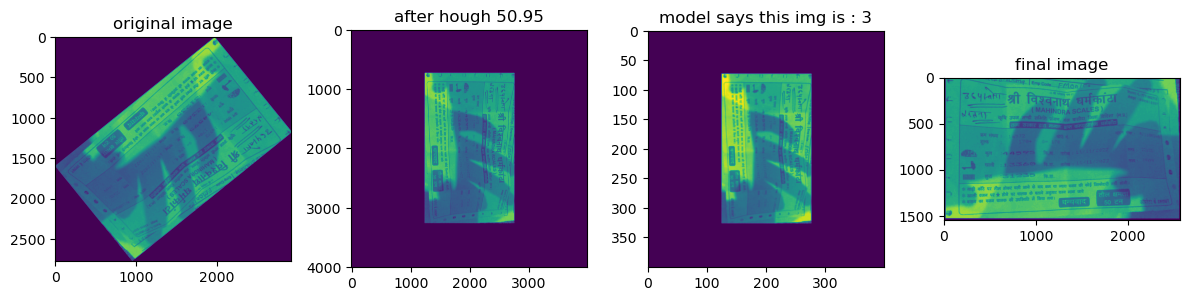

classical rectify done in 8.17s
model prediction done in 0.73s
final rectify done in 0.14s
Total skew_correction done in 9.04s


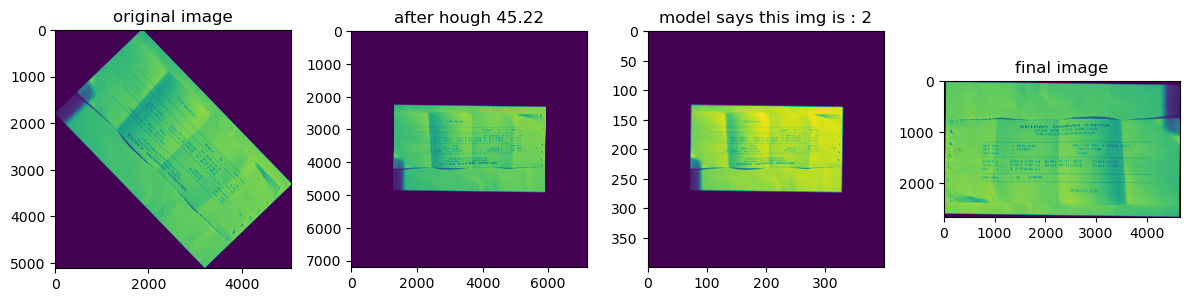

classical rectify done in 6.35s
model prediction done in 0.71s
final rectify done in 0.1s
Total skew_correction done in 7.17s


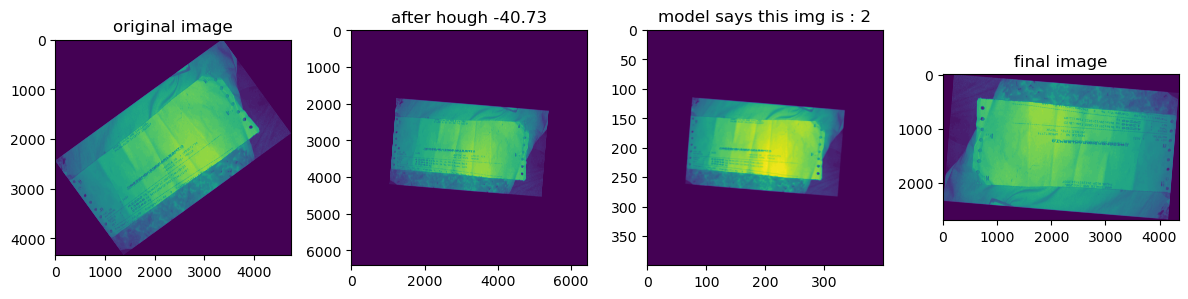

classical rectify done in 0.26s
model prediction done in 0.61s
final rectify done in 0.01s
Total skew_correction done in 0.88s


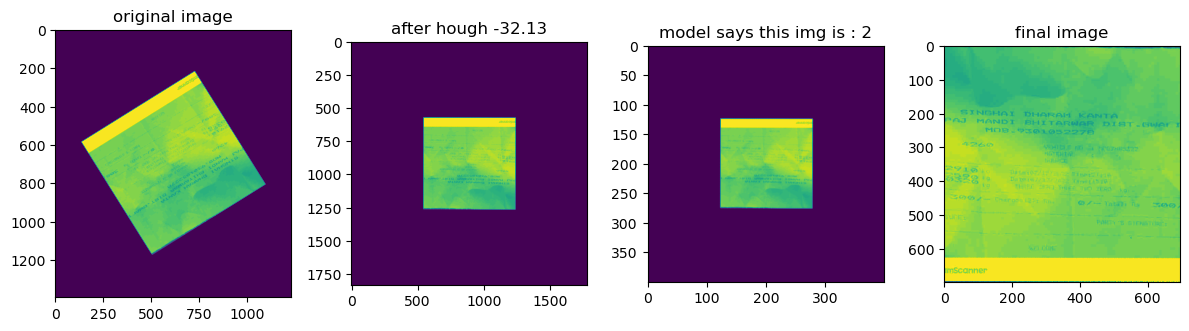

In [34]:
res = predict_onebyone_in_dir(
    folder="/home/deepam_minda_farmart_co/fmt/document-alignment-detection/document_alignment_correction/data/rotated_images/prediction",
    max=10,
    save_to_dir=False,
    shuffle=True,
    debug=True,
    model=model
)
# predict_single_tensor(tensor)

In [ ]:
# def test_onebyone_in_dir():
#     imgpaths = get_images_in_dir(folder, return_path=True, shuffle=shuffle)

#     for idx, path in enumerate(imgpaths):
#         if idx>max:
#             break